In [1]:
#pip install torch==1.9.1+cu111 torchvision==0.10.1+cu111 torchaudio==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
#pip freeze > env.txt

In [3]:
import warnings
warnings.filterwarnings(action='ignore')

In [4]:
import torch
print(torch.cuda.is_available())

True


In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [6]:
import zipfile
zip_file=zipfile.ZipFile("./874kDa unit.zip")
zip_file.extractall("874kDa")

In [7]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [8]:
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

In [9]:
import torchvision.models as models
resnet50 = models.resnet50()

In [10]:
import tensorflow.keras

In [11]:
# Check GPU and fix the random seed
import random
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
print(device)

random.seed(777)
torch.manual_seed(777)
if device == 'cuda:1':
    torch.cuda.manual_seed_all(777)

cuda:1


In [12]:
import resnet
conv1x1=resnet.conv1x1
Bottleneck = resnet.Bottleneck
BasicBlock= resnet.BasicBlock

In [13]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=11, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d): #class type matching -> true or false
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        #print(x.shape)
        #x.shape =[1, 16, 32,32]
        x = self.bn1(x)
        x = self.relu(x)
        #x = self.maxpool(x)

        x = self.layer1(x)
        #print(x.shape)
        #x.shape =[1, 128, 32,32]
        x = self.layer2(x)
        #print(x.shape)
        #x.shape =[1, 256, 32,32]
        x = self.layer3(x)
        #print(x.shape)
        #x.shape =[1, 512, 16,16]
        x = self.layer4(x)
        #print(x.shape)
        #x.shape =[1, 1024, 8,8]
        
        x = self.avgpool(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x
resnet50 = ResNet(resnet.Bottleneck, [3, 4, 6, 3], 11, True).to(device)
#1(conv1) + 9(layer1) + 12(layer2) + 18(layer3) + 9(layer4) +1(fc)= ResNet50

In [14]:
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

**K_FOLD(적절한 튜닝 파라미터 찾기 위해 진행)**

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)


Fold : 1, train : 4400, test : 1100

Epoch: 0
Loss: 2.43, Acc: 6.25% (2/32)
Loss: 2.70, Acc: 9.16% (296/3232)
Loss: 2.63, Acc: 9.14% (402/4400)

Epoch: 1
Loss: 2.38, Acc: 15.62% (5/32)
Loss: 2.16, Acc: 17.36% (561/3232)
Loss: 2.09, Acc: 18.36% (808/4400)

Epoch: 2
Loss: 1.89, Acc: 21.88% (7/32)
Loss: 1.56, Acc: 39.11% (1264/3232)
Loss: 1.36, Acc: 47.50% (2090/4400)

Epoch: 3
Loss: 0.61, Acc: 75.00% (24/32)
Loss: 0.59, Acc: 78.90% (2550/3232)
Loss: 0.57, Acc: 79.55% (3500/4400)

Epoch: 4
Loss: 0.29, Acc: 90.62% (29/32)
Loss: 0.41, Acc: 83.79% (2708/3232)
Loss: 0.41, Acc: 84.14% (3702/4400)

Epoch: 5
Loss: 0.30, Acc: 84.38% (27/32)
Loss: 0.38, Acc: 85.24% (2755/3232)
Loss: 0.37, Acc: 85.84% (3777/4400)

Epoch: 6
Loss: 0.38, Acc: 87.50% (28/32)
Loss: 0.37, Acc: 85.24% (2755/3232)
Loss: 0.37, Acc: 85.48% (3761/4400)

Epoch: 7
Loss: 0.32, Acc: 81.25% (26/32)
Loss: 0.34, Acc: 87.07% (2814/3232)
Loss: 0.34, Acc: 86.91% (3824/4400)

Epoch: 8
Loss: 0.27, Acc: 90.62% (29/32)
Loss: 0.34, Acc: 87

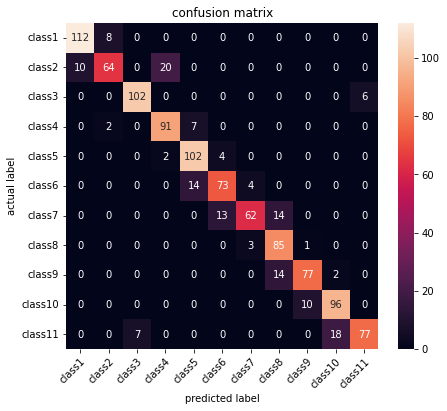

Accuracy for fold 0: 85 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 0 FOLDS
--------------------------------
Fold 0: 85.54545454545455 %
Average: 85.54545454545455 %

Fold : 2, train : 4400, test : 1100

Epoch: 0
Loss: 0.40, Acc: 75.00% (24/32)
Loss: 0.35, Acc: 86.05% (2781/3232)
Loss: 0.35, Acc: 86.66% (3813/4400)

Epoch: 1
Loss: 0.18, Acc: 96.88% (31/32)
Loss: 0.32, Acc: 88.03% (2845/3232)
Loss: 0.32, Acc: 88.16% (3879/4400)

Epoch: 2
Loss: 0.24, Acc: 93.75% (30/32)
Loss: 0.31, Acc: 88.09% (2847/3232)
Loss: 0.30, Acc: 88.34% (3887/4400)

Epoch: 3
Loss: 0.27, Acc: 93.75% (30/32)
Loss: 0.30, Acc: 88.27% (2853/3232)
Loss: 0.31, Acc: 88.07% (3875/4400)

Epoch: 4
Loss: 0.30, Acc: 84.38% (27/32)
Loss: 0.29, Acc: 89.48% (2892/3232)
Loss: 0.30, Acc: 88.82% (3908/4400)

Epoch: 5
Loss: 0.48, Acc: 81.25% (26/32)
Loss: 0.32, Acc: 88.27% (2853/3232)
Loss: 0.32, Acc: 87.89% (3867/4400)

Epoch: 6
Loss: 0.27, Acc: 87.50% (28/32)
Loss: 0.29, Acc: 89.29% (2886/3232)
Loss: 0.

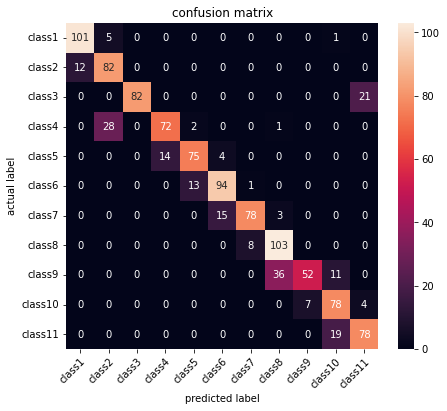

Accuracy for fold 1: 81 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 1 FOLDS
--------------------------------
Fold 0: 85.54545454545455 %
Average: 42.77272727272727 %
Fold 1: 81.36363636363636 %
Average: 83.45454545454545 %

Fold : 3, train : 4400, test : 1100

Epoch: 0
Loss: 0.27, Acc: 90.62% (29/32)
Loss: 0.31, Acc: 87.65% (2833/3232)
Loss: 0.31, Acc: 87.86% (3866/4400)

Epoch: 1
Loss: 0.20, Acc: 87.50% (28/32)
Loss: 0.28, Acc: 89.76% (2901/3232)
Loss: 0.29, Acc: 89.45% (3936/4400)

Epoch: 2
Loss: 0.33, Acc: 84.38% (27/32)
Loss: 0.26, Acc: 89.54% (2894/3232)
Loss: 0.26, Acc: 89.89% (3955/4400)

Epoch: 3
Loss: 0.22, Acc: 93.75% (30/32)
Loss: 0.29, Acc: 88.58% (2863/3232)
Loss: 0.29, Acc: 88.64% (3900/4400)

Epoch: 4
Loss: 0.20, Acc: 93.75% (30/32)
Loss: 0.27, Acc: 89.67% (2898/3232)
Loss: 0.28, Acc: 89.05% (3918/4400)

Epoch: 5
Loss: 0.15, Acc: 96.88% (31/32)
Loss: 0.28, Acc: 89.23% (2884/3232)
Loss: 0.28, Acc: 89.20% (3925/4400)

Epoch: 6
Loss: 0.24, Acc: 90

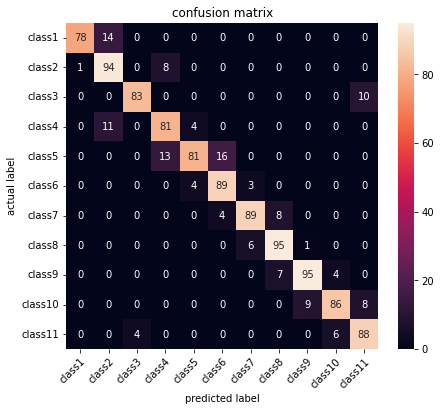

Accuracy for fold 2: 87 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 2 FOLDS
--------------------------------
Fold 0: 85.54545454545455 %
Average: 28.515151515151516 %
Fold 1: 81.36363636363636 %
Average: 55.63636363636363 %
Fold 2: 87.18181818181819 %
Average: 84.6969696969697 %

Fold : 4, train : 4400, test : 1100

Epoch: 0
Loss: 0.33, Acc: 90.62% (29/32)
Loss: 0.29, Acc: 88.71% (2867/3232)
Loss: 0.29, Acc: 88.91% (3912/4400)

Epoch: 1
Loss: 0.24, Acc: 90.62% (29/32)
Loss: 0.26, Acc: 90.13% (2913/3232)
Loss: 0.27, Acc: 89.93% (3957/4400)

Epoch: 2
Loss: 0.24, Acc: 90.62% (29/32)
Loss: 0.28, Acc: 88.80% (2870/3232)
Loss: 0.28, Acc: 89.09% (3920/4400)

Epoch: 3
Loss: 0.17, Acc: 96.88% (31/32)
Loss: 0.25, Acc: 90.01% (2909/3232)
Loss: 0.27, Acc: 89.43% (3935/4400)

Epoch: 4
Loss: 0.21, Acc: 90.62% (29/32)
Loss: 0.27, Acc: 89.70% (2899/3232)
Loss: 0.26, Acc: 90.02% (3961/4400)

Epoch: 5
Loss: 0.22, Acc: 90.62% (29/32)
Loss: 0.26, Acc: 90.10% (2912/3232)
Loss: 0.

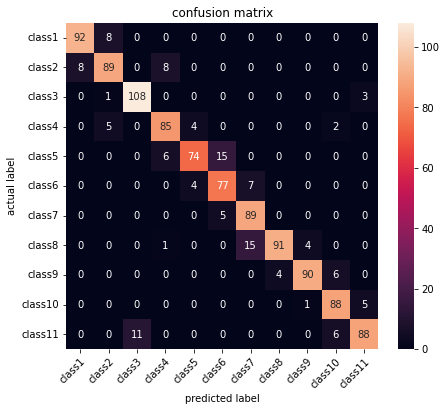

Accuracy for fold 3: 88 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 3 FOLDS
--------------------------------
Fold 0: 85.54545454545455 %
Average: 21.386363636363637 %
Fold 1: 81.36363636363636 %
Average: 41.72727272727273 %
Fold 2: 87.18181818181819 %
Average: 63.52272727272727 %
Fold 3: 88.27272727272727 %
Average: 85.5909090909091 %

Fold : 5, train : 4400, test : 1100

Epoch: 0
Loss: 0.21, Acc: 96.88% (31/32)
Loss: 0.26, Acc: 89.85% (2904/3232)
Loss: 0.27, Acc: 89.64% (3944/4400)

Epoch: 1
Loss: 0.16, Acc: 96.88% (31/32)
Loss: 0.22, Acc: 91.92% (2971/3232)
Loss: 0.23, Acc: 91.39% (4021/4400)

Epoch: 2
Loss: 0.16, Acc: 90.62% (29/32)
Loss: 0.24, Acc: 90.56% (2927/3232)
Loss: 0.25, Acc: 90.36% (3976/4400)

Epoch: 3
Loss: 0.22, Acc: 90.62% (29/32)
Loss: 0.23, Acc: 91.40% (2954/3232)
Loss: 0.23, Acc: 91.25% (4015/4400)

Epoch: 4
Loss: 0.21, Acc: 93.75% (30/32)
Loss: 0.23, Acc: 91.43% (2955/3232)
Loss: 0.23, Acc: 91.16% (4011/4400)

Epoch: 5
Loss: 0.13, Acc: 96

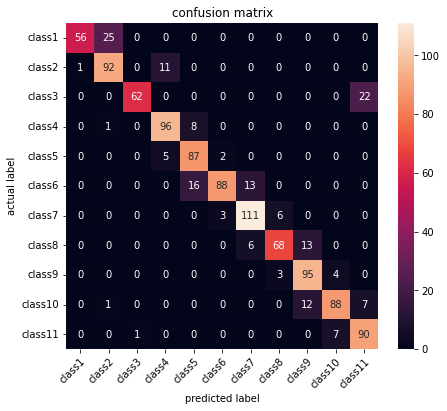

Accuracy for fold 4: 84 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 4 FOLDS
--------------------------------
Fold 0: 85.54545454545455 %
Average: 17.10909090909091 %
Fold 1: 81.36363636363636 %
Average: 33.38181818181818 %
Fold 2: 87.18181818181819 %
Average: 50.81818181818182 %
Fold 3: 88.27272727272727 %
Average: 68.47272727272727 %
Fold 4: 84.81818181818181 %
Average: 85.43636363636364 %


In [16]:
import pandas as pd
from sklearn.model_selection import KFold
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_score, recall_score,f1_score, roc_curve
from sklearn.metrics import classification_report 


data_dir="./874kDa"
results = {}
#transforms methods (size, shape transform : to tensor)
train_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       ])    
train_data = datasets.ImageFolder(data_dir,transform=train_transforms)
   
kf= KFold(n_splits=5,shuffle=True, random_state=42)

for j,(train_idx,test_idx) in enumerate(kf.split(train_data)):
    train = torch.utils.data.Subset(train_data, train_idx)
    test = torch.utils.data.Subset(train_data, test_idx)
    trainloader = torch.utils.data.DataLoader(train, batch_size=32, num_workers=2, shuffle=True)
    testloader = torch.utils.data.DataLoader(test, batch_size=32, num_workers=2, shuffle=True)
    print("")
    print('Fold : {}, train : {}, test : {}'.format(j+1, len(trainloader.dataset), len(testloader.dataset)))

    for epoch in range(15):
      print('\nEpoch: %d' % epoch)
      resnet50.train()
      train_loss = 0
      correct = 0
      total = 0

      for batch_idx, (inputs, targets) in enumerate(trainloader):
        #print('batch idx : ',batch_idx)
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = resnet50(inputs).to(device) #output = 각 클래스 별 확률, 16개 return
        loss = criterion(outputs, targets) #output = 예측값, target = 원래 정답
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1) # 32개 이미지 각각에서 가장 큰 확률 값을 가져옴 predicted = 예측한 클래스 
        total += targets.size(0) # Accuracy 를 구해야하므로 전체 dataset 이 몇개 인지를 iterative 하게 update (target size = 배치 안의 이미지 개수)
        correct += predicted.eq(targets).sum().item() 
        del(inputs,targets)
        if batch_idx % 100 == 0:
          print('Loss: %.2f, Acc: %.2f%% (%d/%d)' 
                % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
      print('Loss: %.2f, Acc: %.2f%% (%d/%d)' 
                % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))       

    with torch.no_grad():
        resnet50.eval()
        test_loss = 0
        correct = 0
        total = 0
        y_predict_list=[]
        y_true_list=[] 
        for i, (inputs, targets) in enumerate(testloader,0):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = resnet50(inputs).to(device)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            y_predict_list += [int(o.argmax()) for o in outputs]
            y_true_list += [int(r) for r in targets]
            result = classification_report( y_true_list,y_predict_list, output_dict=True)
        print(result)
    print('Loss: %.2f, Acc: %.2f%% (%d/%d)'% (test_loss / (i + 1), 100. * correct / total, correct, total))
    
        
    #confusioin matrix for this fold
    nb_classes=11
    confusion_matrix = torch.zeros(nb_classes,nb_classes)
    with torch.no_grad():    
          for i, (inputs, classes) in enumerate(testloader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = resnet50(inputs)
            _, preds = torch.max(outputs, 1)
            for t,p in zip(classes.view(-1),preds.view(-1)):
                confusion_matrix[t.long(),p.long()] += 1
    classes=['class1','class2','class3','class4','class5','class6','class7','class8','class9','class10','class11']
    conf_mat = confusion_matrix
    fig,ax=plt.subplots(figsize=(7,6))
    sns.heatmap(conf_mat,annot=True,fmt='.0f',xticklabels=classes,yticklabels=classes)
    plt.setp(ax.get_xticklabels(),rotation=45,ha="right",rotation_mode='anchor')
    plt.title('confusion matrix')
    plt.ylabel('actual label')
    plt.xlabel('predicted label')
    plt.show()

    # Print accuracy
    print('Accuracy for fold %d: %d %%' % (j, 100.0 * correct / total))
    print('--------------------------------')
    results[j] = 100.0 * (correct / total)
    
    # Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {j} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in results.items():
        print(f'Fold {key}: {value} %')
        sum += value
        print(f'Average: {sum/len(results.items())} %')

In [18]:
print('k-fold average:')
(85.55+81.36+87.18+88.27+84.81)/5

k-fold average:


85.434